In [1]:
import numpy as np
import pandas as pd

from tqdm import tqdm

import networkx as nx
import gudhi as gd
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

import pickle

from copy import copy, deepcopy

import ecc_graphs

In [2]:
def compute_ECC(graphs_dict, create_flag=True, normalize=True):
    ecc_list = []
    labels = []

    for idx in tqdm(graphs_dict.keys()):
        # create graph
        G = nx.Graph()
        G.add_edges_from(graphs_dict[idx]['edges'])

        # add filtration values
        for node in G.nodes:
            G.nodes[node]['weight'] = nx.degree(G, node)

        for edge in G.edges:
            degrees = [d[1] for d in nx.degree(G, edge)]
            G.edges[edge]['weight'] = max(degrees)

        # create simplicial complex from graph
        simplex_tree = gd.SimplexTree()

        if create_flag:
            # insert higher dim simplicies
            for clique_list in nx.find_cliques(G):
                clique = [v for v in clique_list]
                simplex_tree.insert(clique, filtration=max([G.nodes[node]['weight'] for node in clique]))
        else:
            # insert only nodes and edges
            for node in G.nodes.data('weight'):
                simplex_tree.insert([node[0]], filtration=node[1])
            for edge in G.edges.data('weight'):
                simplex_tree.insert([edge[0], edge[1]], filtration=edge[2])

        # compute ECC
        c_list, num_simplicies = ecc_graphs.compute_local_contributions(simplex_tree)
        ecc = ecc_graphs.euler_characteristic_list(c_list)

        # save ECC divided by number of nodes
        if normalize:
            ecc[:,1] = ecc[:,1] / len(G.nodes)
        
        # save ECC
        ecc_list.append(ecc)
        labels.append(graphs_dict[idx]['label'])
        
    return ecc_list, labels

In [3]:
def normalize_ECC(ecc_list):
    norm_list = []
    for ecc in tqdm(ecc_list):
        n_ecc = deepcopy(ecc)
        n_ecc[:, 0] = n_ecc[:, 0] / max(n_ecc[:, 0])
        norm_list.append(n_ecc)
        
    return norm_list

In [4]:
def vectorize_ECC(ecc_list):
    vectorized_ecc = []
    
    for ecc in tqdm(ecc_list):
        vec_e = []
        for x in range(1, 101):
            i = 0
            while ecc[i, 0] < x/100:
                i += 1
            vec_e.append([x/100, ecc[i-1, 1]])
        vec_e[-1] = [1, ecc[-1, 1]]
        
        vectorized_ecc.append(vec_e)
        
    return np.array(vectorized_ecc)
    

In [5]:
def plot(data_list, labels):
    # Plot ECC
    plt.close('all')
    plt.figure(figsize=(16,12))

    cmap = plt.get_cmap("tab10")

    for idx in range(1, 5000, 50):
        data = data_list[idx-1]

        plt.plot(data[:, 0], data[:, 1], 
                     label='{}'.format(idx),
                     color = cmap(labels[idx-1]))

    plt.xlabel('Filtration', fontsize=18)
    plt.ylabel('EC', fontsize=18)
    plt.title('ECC', fontsize=18)
    plt.grid()
    #plt.legend(fontsize=14)
    plt.tight_layout()
    # plt.savefig("CV_eta.pdf")
    # files.download("CV_eta.pdf")
    plt.show()

# Reddit 5k

In [11]:
graphs_dict_5 = pickle.load( open( "graphs_dict_5k.pkl", "rb" ) )

In [12]:
ecc_5_list, labels_5 = compute_ECC(graphs_dict_5)

100%|██████████| 4999/4999 [04:08<00:00, 20.13it/s]


In [13]:
norm_5_list = normalize_ECC(ecc_5_list)

100%|██████████| 4999/4999 [00:00<00:00, 21495.25it/s]


In [14]:
vec_5_list = vectorize_ECC(norm_5_list)

100%|██████████| 4999/4999 [00:05<00:00, 978.22it/s] 


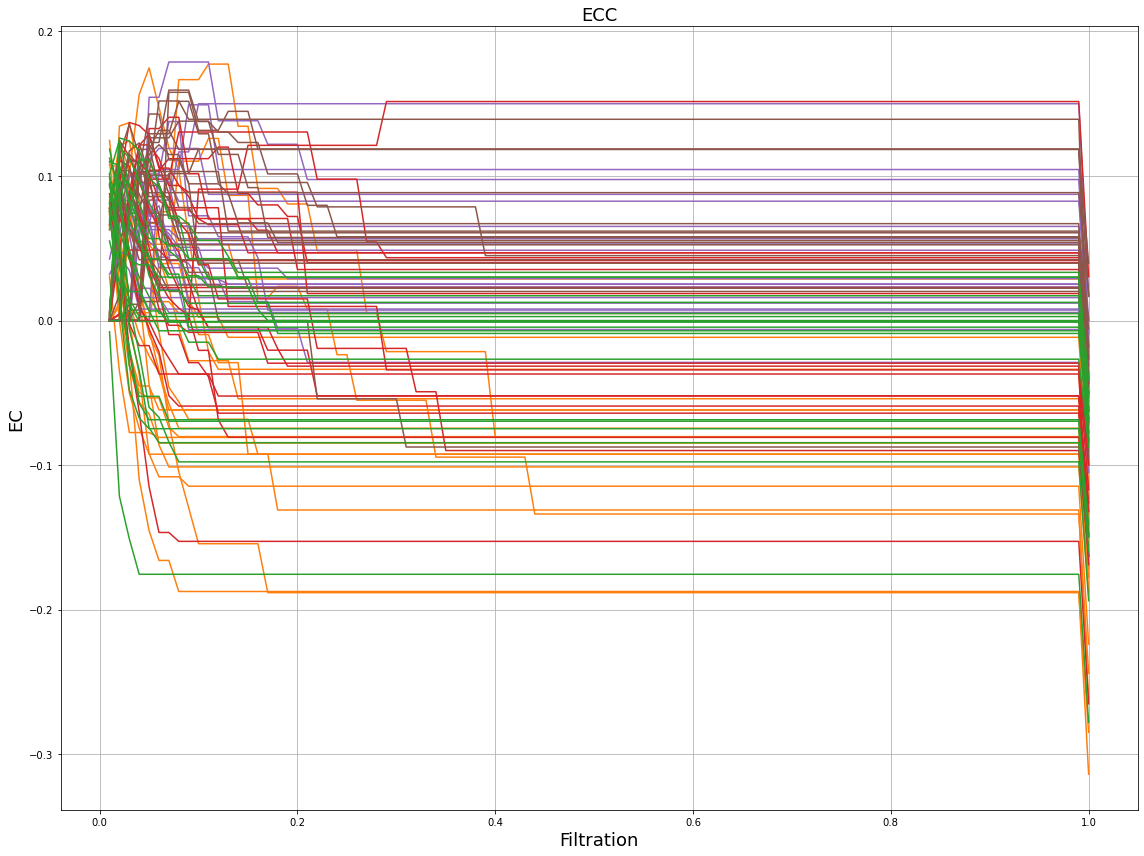

In [15]:
plot(vec_5_list, labels_5)

In [16]:
!mkdir NN/REDDIT-MULTI-5K

In [17]:
np.savetxt("NN/REDDIT-MULTI-5K/vec_ECC.csv", vec_5_list[: , : , 1], delimiter=",")
np.savetxt("NN/REDDIT-MULTI-5K/labels.csv", labels_5, delimiter=",")

# Reddit 12k

In [18]:
graphs_dict_12 = pickle.load( open( "graphs_dict_12k.pkl", "rb" ) )

In [20]:
ecc_12_list, labels_12 = compute_ECC(graphs_dict_12)

100%|██████████| 11929/11929 [18:23<00:00, 10.81it/s]  


In [21]:
norm_12_list = normalize_ECC(ecc_12_list)

100%|██████████| 11929/11929 [00:00<00:00, 16790.13it/s]


In [22]:
vec_12_list = vectorize_ECC(norm_12_list)

100%|██████████| 11929/11929 [00:11<00:00, 1020.70it/s]


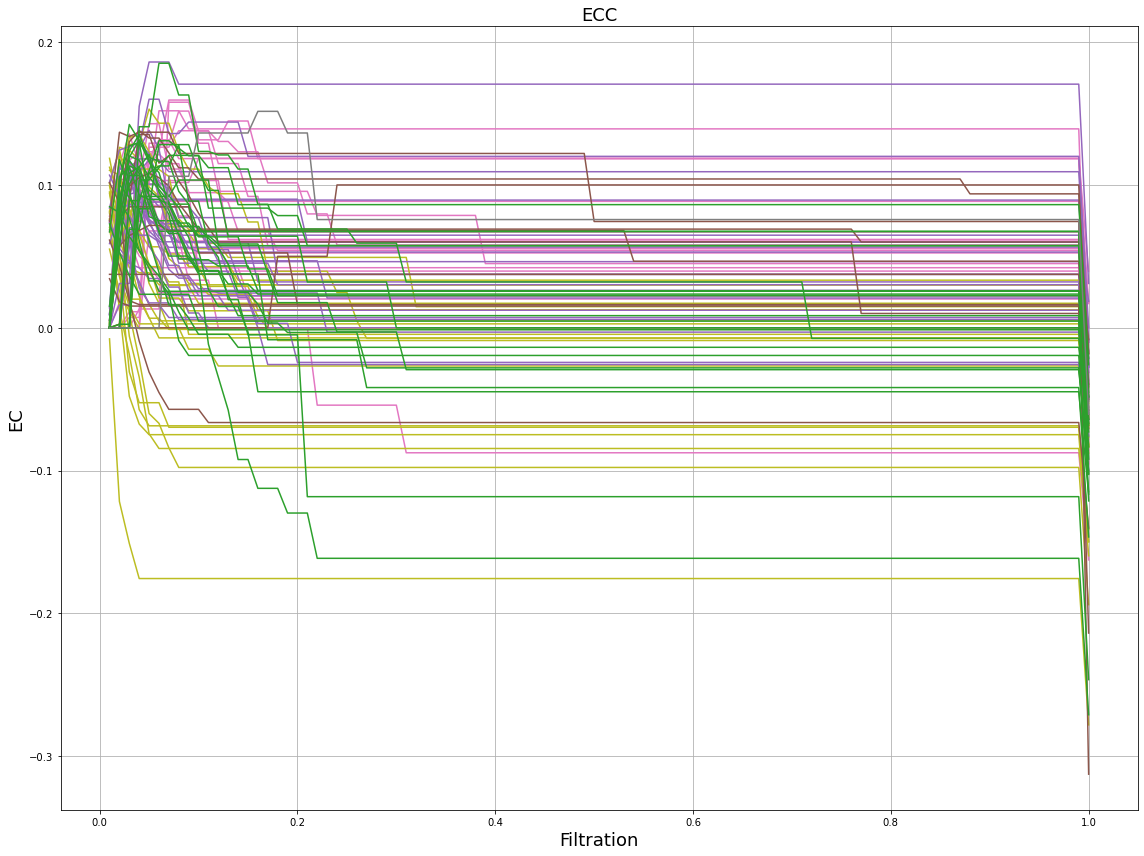

In [23]:
plot(vec_12_list, labels_12)

In [24]:
!mkdir NN/REDDIT-MULTI-12K

In [25]:
np.savetxt("NN/REDDIT-MULTI-12K/vec_ECC.csv", vec_12_list[: , : , 1], delimiter=",")
np.savetxt("NN/REDDIT-MULTI-12K/labels.csv", labels_12, delimiter=",")

In [27]:
len(pd.unique(labels_12))

11